# Assignment 5: Text Processing
# CS 533 Fall 2019

**Arash Modaresi Rad**

## Requirements

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import glob
from sklearn import metrics
import sklearn.metrics as metrics
from pathlib import Path
import scipy.sparse as sps

We need text processing libraries from SciKit-Learn:

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
import sklearn.linear_model as lm
import sklearn.naive_bayes as nb
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score

And set our random seed - this will make the notebook work the same for reproducibility:

In [3]:
np.random.seed(11072019)

In [4]:
seed = 11072019

Direct reproduciblity is good for debugging, but check w/ another seed to look for flukes.

## Part 1: Load and Prepare Data

Read the data:

In [5]:
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text())
     for f in Path('Data/bbc').glob('*/*.txt')),
    columns=['category', 'file', 'text']
)

This loops over all text files and reads them into records, that you then turn into a Pandas data frame.

In [6]:
articles.head()

,category,file,text
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,004.txt,High fuel prices hit BA's profits\n\nBritish A...
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...


1.	Show the distribution of categories - how many articles are there in each category? Do this with a suitable plot.

In [7]:
articles['value'] = 1
#articles.head()

In [8]:
catagory_counts = pd.DataFrame(articles.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
#catagory_counts.head()

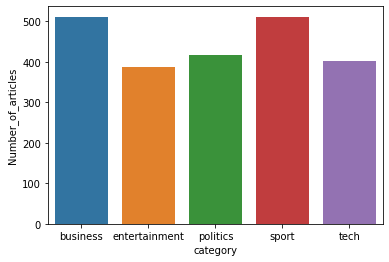

In [9]:
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

2.	Select 20% of the data for testing your classifiers.

Let's make train and test data sets:

In [10]:
articles_test = articles.sample(frac=0.20, random_state = seed)
train_mask = pd.Series(True, index=articles.index)
train_mask[articles_test.index] = False
articles_train = articles[train_mask]
assert len(articles_test) + len(articles_train) == len(articles)

In [11]:
articles_test

,category,file,text,value
2167,tech,344.txt,Virgin Radio offers 3G broadcast\n\nUK broadca...,1
151,business,152.txt,Crude oil prices back above $50\n\nCold weathe...,1
1407,sport,095.txt,Man Utd stroll to Cup win\n\nWayne Rooney made...,1
448,business,449.txt,Wal-Mart fights back at accusers\n\nTwo big US...,1
1821,sport,509.txt,Melzer shocks Agassi in San Jose\n\nSecond see...,1
...,...,...,...,...
1276,politics,381.txt,Hunt ban support is 'in decline'\n\nSupport fo...,1
2091,tech,268.txt,IBM frees 500 software patents\n\nComputer gia...,1
955,politics,060.txt,Cardinal criticises Iraq war cost\n\nBillions ...,1
1413,sport,101.txt,Man City 0-2 Man Utd\n\nManchester United redu...,1


3.	Set up a CountVectorizer and a TfidfVectorizer, each with “stop_words='english'” and transform your training and test data into document-term matrices.

Let's process our text into *bag of words*

In [12]:
txtcount = CountVectorizer(stop_words='english')
train_BW = txtcount.fit_transform(articles_train['text'])
txtcount.get_feature_names()[:10]

['00', '000', '0001', '000bn', '000m', '000s', '000th', '001st', '004', '0051']

In [13]:
vectorizer = TfidfVectorizer(stop_words='english')
train_Tfidf = vectorizer.fit_transform(articles_train['text'])
vectorizer.get_feature_names()[:10]

['00', '000', '0001', '000bn', '000m', '000s', '000th', '001st', '004', '0051']

The result is a *sparse matrix*.  Each row is a document, and each column is a word.  It only stores the nonzero values.  We can get the words that correspond to each column from the counter:

We will also need the test data turned into a matrix. We will use the same counter object, but will use transform because we do not want to update it with the test data.

In [14]:
test_BW = txtcount.transform(articles_test['text'])
test_Tfidf = vectorizer.transform(articles_test['text'])

## Part 2: Classification

Train a Naive Bayes classifier on your training data (using count vectors), and test its accuracy on both the training data and the test data. Naive Bayes can handle more than 2 classes just fine.

**Naive Bayes**

In [15]:
bayes = nb.MultinomialNB()
bayes.fit(train_BW, articles_train['category'])
bayes.feature_log_prob_

array([[-11.55219425,  -6.27407959, -11.55219425, ..., -11.55219425,
        -11.55219425, -11.55219425],
       [-11.34299087,  -6.71801806, -11.34299087, ..., -10.64984369,
        -11.34299087, -10.64984369],
       [-10.85910476,  -6.78156732, -10.85910476, ..., -11.55225194,
        -11.55225194, -11.55225194],
       [-10.79731793,  -8.27158928, -11.49046511, ..., -11.49046511,
         -9.8810272 , -11.49046511],
       [-10.93130177,  -6.58749635, -11.62444895, ..., -11.62444895,
        -11.62444895, -11.62444895]])

We can get its view of classes from `classes_`:

In [16]:
bayes.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype='<U13')

What is the training accuracy of this classifier?

In [17]:
(articles_train['category'] == bayes.predict(train_BW)).mean()

0.9926966292134831

And its test accuracy?

In [18]:
(articles_test['category'] == bayes.predict(test_BW)).mean()

0.9820224719101124

Since test accurecy is lower than training accurecy we can assume that the classifier is not overfitting.

Let's look at words.  The log probability matrix is $2 \times k$; let's transpose that and make a data frame:

In [19]:
nb_words = pd.DataFrame(bayes.feature_log_prob_.T, index=txtcount.get_feature_names(),
                        columns=['lp_business', 'lp_entertainment', 'lp_politics', 'lp_sport', 'lp_tech'])
nb_words.head()

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech
00,-11.552194,-11.342991,-10.859105,-10.797318,-10.931302
000,-6.274080,-6.718018,-6.781567,-8.271589,-6.587496
0001,-11.552194,-11.342991,-10.859105,-11.490465,-11.624449
000bn,-10.859047,-11.342991,-11.552252,-11.490465,-11.624449
000m,-11.552194,-11.342991,-11.552252,-7.993958,-11.624449


What words have the highest $P(business|w)$?

In [20]:
nb_words.nlargest(5, 'lp_business')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech
said,-4.303690,-4.799079,-4.081458,-4.792197,-4.479253
year,-5.160277,-5.437629,-6.181614,-5.496504,-5.958022
mr,-5.349659,-6.280396,-4.359318,-8.717876,-5.637997
market,-5.674458,-8.509778,-8.333376,-11.490465,-6.398702
new,-5.714464,-5.786163,-5.705813,-5.985134,-5.549103


What words have the highest $P(entertainment|w)$?

In [21]:
nb_words.nlargest(5, 'lp_entertainment')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech
said,-4.303690,-4.799079,-4.081458,-4.792197,-4.479253
film,-9.249609,-4.887792,-9.472810,-11.490465,-7.465566
best,-7.745532,-5.087241,-7.814582,-6.500033,-7.564006
music,-8.913137,-5.400191,-10.453640,-11.490465,-5.828391
year,-5.160277,-5.437629,-6.181614,-5.496504,-5.958022


What words have the highest $P(politics|w)$?

In [22]:
nb_words.nlargest(5, 'lp_politics')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech
said,-4.303690,-4.799079,-4.081458,-4.792197,-4.479253
mr,-5.349659,-6.280396,-4.359318,-8.717876,-5.637997
labour,-8.507672,-9.733553,-5.130630,-11.490465,-10.525837
government,-5.939066,-7.909004,-5.180640,-10.797318,-7.774301
people,-6.676997,-6.155605,-5.333652,-7.270957,-4.936094


What words have the highest $P(sport|w)$?

In [23]:
nb_words.nlargest(5, 'lp_sport')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech
said,-4.303690,-4.799079,-4.081458,-4.792197,-4.479253
game,-9.606284,-7.759472,-9.154357,-5.469442,-6.048500
year,-5.160277,-5.437629,-6.181614,-5.496504,-5.958022
england,-7.838622,-8.570402,-7.393369,-5.509051,-9.427224
time,-6.624941,-6.255395,-6.422353,-5.621168,-6.115061


What words have the highest $P(tech|w)$?

In [24]:
nb_words.nlargest(5, 'lp_tech')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech
said,-4.303690,-4.799079,-4.081458,-4.792197,-4.479253
people,-6.676997,-6.155605,-5.333652,-7.270957,-4.936094
new,-5.714464,-5.786163,-5.705813,-5.985134,-5.549103
technology,-8.219990,-9.733553,-9.249667,-9.411024,-5.601001
mr,-5.349659,-6.280396,-4.359318,-8.717876,-5.637997


What words have the highest *conditional catagory* of spam?  Conditional odds is the conditional probability, turned into odds:

$$O(catagory|w) = \frac{P(catagory|w)}{P(\neg catagory|w)} = \frac{P(catagory|w)}{P(other catagories|w)}$$

But everything here is *log* probabiltiies, remember? So we will compute log odds:

The log odds for business catagory:

In [25]:
nb_words['log_odds'] = nb_words['lp_business'] - (nb_words['lp_entertainment'] + nb_words['lp_politics'] + nb_words['lp_sport'] + nb_words['lp_tech'])
nb_words.nlargest(5, 'log_odds')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech,log_odds
yukos,-6.617720,-11.342991,-11.552252,-11.490465,-11.624449,39.392437
gm,-7.133354,-11.342991,-11.552252,-11.490465,-11.624449,38.876803
fiat,-7.261735,-11.342991,-11.552252,-11.490465,-11.624449,38.748422
gazprom,-7.347502,-11.342991,-11.552252,-11.490465,-11.624449,38.662655
lse,-7.457850,-11.342991,-11.552252,-11.490465,-11.624449,38.552307


The log odds for entertainment catagory:

In [26]:
nb_words['log_odds'] = nb_words['lp_entertainment'] - (nb_words['lp_business'] + nb_words['lp_politics'] + nb_words['lp_sport'] + nb_words['lp_tech'])
nb_words.nlargest(5, 'log_odds')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech,log_odds
actress,-11.552194,-6.445151,-11.552252,-11.490465,-11.624449,39.774209
festival,-11.552194,-6.747871,-11.552252,-11.490465,-11.624449,39.471489
aviator,-11.552194,-6.799696,-11.552252,-11.490465,-11.624449,39.419664
oscar,-11.552194,-6.563867,-10.859105,-11.490465,-11.624449,38.962346
foxx,-11.552194,-7.299940,-11.552252,-11.490465,-11.624449,38.919421


The log odds for politics catagory:

In [27]:
nb_words['log_odds'] = nb_words['lp_politics'] - (nb_words['lp_business'] + nb_words['lp_entertainment'] + nb_words['lp_sport'] + nb_words['lp_tech'])
nb_words.nlargest(5, 'log_odds')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech,log_odds
tory,-11.552194,-11.342991,-6.154089,-11.490465,-11.624449,39.856010
tories,-11.552194,-11.342991,-6.342766,-11.490465,-11.624449,39.667333
lib,-11.552194,-11.342991,-6.568645,-11.490465,-11.624449,39.441454
ukip,-11.552194,-11.342991,-6.748231,-11.490465,-11.624449,39.261868
kilroy,-11.552194,-11.342991,-6.851772,-11.490465,-11.624449,39.158328


The log odds for sport catagory:

In [28]:
nb_words['log_odds'] = nb_words['lp_sport'] - (nb_words['lp_business'] + nb_words['lp_entertainment'] + nb_words['lp_politics'] + nb_words['lp_tech'])
nb_words.nlargest(5, 'log_odds')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech,log_odds
roddick,-11.552194,-11.342991,-11.552252,-6.745533,-11.624449,39.326353
championships,-11.552194,-11.342991,-11.552252,-7.213799,-11.624449,38.858087
referee,-11.552194,-11.342991,-11.552252,-7.256359,-11.624449,38.815527
mourinho,-11.552194,-11.342991,-11.552252,-7.347330,-11.624449,38.724556
nadal,-11.552194,-11.342991,-11.552252,-7.363331,-11.624449,38.708555


The log odds for tech catagory:

In [29]:
nb_words['log_odds'] = nb_words['lp_tech'] - (nb_words['lp_business'] + nb_words['lp_entertainment'] + nb_words['lp_politics'] + nb_words['lp_sport'])
nb_words.nlargest(5, 'log_odds')

,lp_business,lp_entertainment,lp_politics,lp_sport,lp_tech,log_odds
spam,-11.552194,-11.342991,-11.552252,-11.490465,-7.029329,38.908573
portable,-11.552194,-11.342991,-11.552252,-11.490465,-7.158541,38.779361
apple,-11.552194,-11.342991,-11.552252,-10.797318,-6.555545,38.689210
mobiles,-11.552194,-11.342991,-11.552252,-11.490465,-7.293716,38.644187
gadgets,-11.552194,-11.342991,-11.552252,-11.490465,-7.320384,38.617518


Another way to classify is with “k nearest neighbors”: to classify a document, find the closest data points and use the class most of them have. The KNeighborsClassifier in scikit-learn does this. Train one of these classifiers (with TF-IDF vectors), using 5 neighbors, and measure its accuracy on both training and test data.

Create KNN classifier

In [30]:
knn = KNeighborsClassifier(n_neighbors = 5)

Fit the classifier to the data

In [31]:
knn.fit(train_Tfidf, articles_train['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
#knn.feature_log_prob_

In [33]:
articles_train.head()

,category,file,text,value
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,1
1,business,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,1
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,1
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,1
5,business,006.txt,Japan narrowly escapes recession\n\nJapan's ec...,1


What is the training accuracy of this classifier?

In [34]:
knn.predict(train_Tfidf)[0:5]

array(['business', 'business', 'business', 'business', 'business'],
      dtype=object)

In [35]:
knn.score(train_Tfidf, articles_train['category'])

0.9584269662921349

Now that the model is trained, we can use the ‘predict’ function on our model to make predictions on our test data.

In [36]:
knn.predict(test_Tfidf)[0:5]

array(['tech', 'business', 'sport', 'business', 'sport'], dtype=object)

In [37]:
knn.score(test_Tfidf, articles_test['category'])

0.9550561797752809

Since test accurecy is lower than training accurecy we can assume that the classifier is not overfitting.

According to the obtained accurecy from both classifiers it is evident that the naive bays classifier using count vectorizer (bag of words) is more accuretly predcting diffrent catgories compared to KNN classifier using Tfidf data.   

## Part 3: Clustering

So far our machine learning has been supervised: we have the labels. We can also do unsupervised learning, where we learn patterns from the data without labels. One such technique is clustering: putting objects (such as documents) into groups, using only the features in the documents and not using external group labels.

`K-means` is a simple way of clustering a group of data points into k clusters. KMeans in scikit-learn implements this; after training, its predict method outputs cluster numbers for data points - this is how you will get the clusters. It’s like the classifier output, except cluster numbers. The most important parameter to KMeans is the number of clusters to find - it cannot do that on its own.


1.	Fit a K-means model with 5 clusters to your data (using the TF-IDF matrix), and get the cluster numbers for your training data.

2.	For each cluster, show the distribution of document categories (from the original labels) in that cluster. This should be 5 bar plots (in a facet grid), each of which has the group/class on the x axis and the number of documents in that cluster with that category on the y axis.

Data pre processing 

In [40]:
train_Tfidf

<1780x26679 sparse matrix of type '<class 'numpy.float64'>'
	with 259693 stored elements in Compressed Sparse Row format>

In [41]:
kmeans = KMeans(5, n_jobs=2)
mks = kmeans.fit_transform(train_Tfidf)

In [44]:
news_cs = pd.DataFrame(mks, index=articles_train.index)
news_cs.head()

,0,1,2,3,4
0,0.980179,1.001297,1.008238,1.038816,0.997430
1,0.971190,1.005633,1.005110,1.024176,1.007415
2,0.985928,1.011584,1.013153,1.037637,1.014600
4,0.997605,1.014645,1.014491,1.045925,1.018149
5,0.982792,1.011341,1.011457,1.036877,1.010464


Now lets look at the clusters!

Cluster 1:

In [68]:
C1 = pd.DataFrame({'distance': news_cs[0].nsmallest(10)}).join(articles_train)
#C1

,distance,category,file,text,value
100,0.955254,business,101.txt,Australia rates at four year high\n\nAustralia...,1
506,0.959147,business,507.txt,UK economy ends year with spurt\n\nThe UK econ...,1
289,0.959399,business,290.txt,Bank holds interest rate at 4.75%\n\nThe Bank ...,1
437,0.959701,business,438.txt,UK interest rates held at 4.75%\n\nThe Bank of...,1
415,0.959864,business,416.txt,Steady job growth continues in US\n\nThe US cr...,1
120,0.959899,business,121.txt,US interest rates increased to 2%\n\nUS intere...,1
164,0.960104,business,165.txt,Consumer spending lifts US growth\n\nUS econom...,1
492,0.960521,business,493.txt,China continues rapid growth\n\nChina's econom...,1
257,0.960801,business,258.txt,S Korea spending boost to economy\n\nSouth Kor...,1
355,0.960801,business,356.txt,S Korea spending boost to economy\n\nSouth Kor...,1


In [56]:
print(C1['category'].unique())

['business']


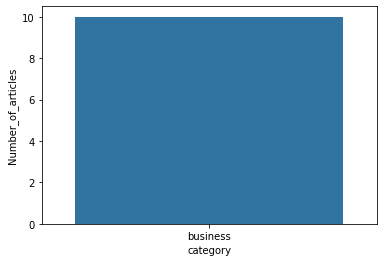

In [69]:
catagory_counts = pd.DataFrame(C1.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

**business is the only catagory from cluster 1**

Cluster 2:

In [59]:
C2 = pd.DataFrame({'distance': news_cs[1].nsmallest(10)}).join(articles_train)
#C2

In [61]:
print(C2['category'].unique())

['entertainment']


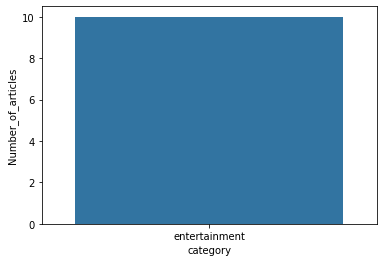

In [70]:
catagory_counts = pd.DataFrame(C2.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

**entertainment is the only catagory from cluster 2**

Cluster 3:

In [62]:
C3 = pd.DataFrame({'distance': news_cs[2].nsmallest(10)}).join(articles_train)
#C3

In [63]:
print(C3['category'].unique())

['sport']


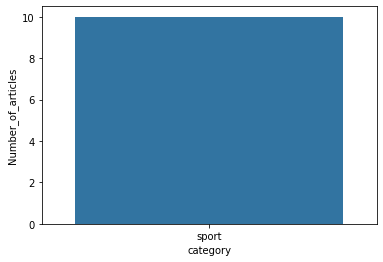

In [71]:
catagory_counts = pd.DataFrame(C3.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

**sport is the only catagory from cluster 3**

Cluster 4:

In [64]:
C4 = pd.DataFrame({'distance': news_cs[3].nsmallest(10)}).join(articles_train)
#C4

In [65]:
print(C4['category'].unique())

['politics']


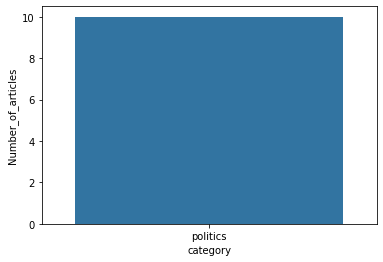

In [72]:
catagory_counts = pd.DataFrame(C4.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

**politics is the only catagory from cluster 4**

Cluster 5:

In [66]:
C5 = pd.DataFrame({'distance': news_cs[4].nsmallest(10)}).join(articles_train)
#C5

In [67]:
print(C5['category'].unique())

['tech']


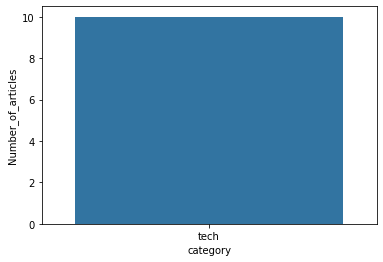

In [73]:
catagory_counts = pd.DataFrame(C5.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

**tech is the only catagory from cluster 4**

3.	Did the clustering do a good job of finding the categories?

Yes, the Kmeans clustering produced the same cluster catagories described by BBC 

4.	Try this again with 6 clusters. Do you think it did a better or worse job? Why do you think that is?

In [74]:
kmeans = KMeans(6, n_jobs=2)
mks = kmeans.fit_transform(train_Tfidf)

In [75]:
news_cs = pd.DataFrame(mks, index=articles_train.index)
news_cs.head()

,0,1,2,3,4,5
0,1.006862,0.992946,1.004234,0.976504,1.050230,1.008146
1,1.018014,0.992758,1.008385,0.964173,1.034200,1.005108
2,1.026977,0.998745,1.014657,0.984787,1.048257,1.013142
4,1.029138,1.005442,1.017468,0.999776,1.056139,1.014219
5,1.018411,1.001589,1.014924,0.976097,1.047091,1.011466


Now lets look at the clusters!

Cluster 1:

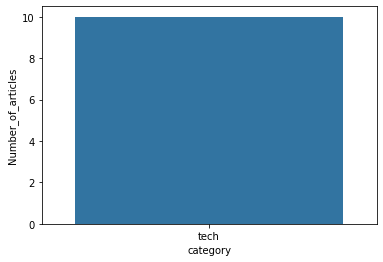

In [78]:
C1 = pd.DataFrame({'distance': news_cs[0].nsmallest(10)}).join(articles_train)
catagory_counts = pd.DataFrame(C1.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

Cluster 2:

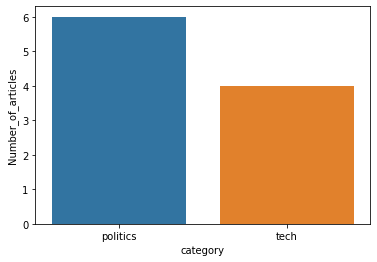

In [79]:
C2 = pd.DataFrame({'distance': news_cs[1].nsmallest(10)}).join(articles_train)
catagory_counts = pd.DataFrame(C2.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

Cluster 3:

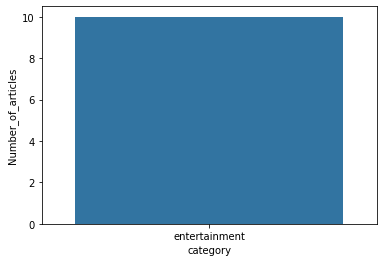

In [80]:
C3 = pd.DataFrame({'distance': news_cs[2].nsmallest(10)}).join(articles_train)
catagory_counts = pd.DataFrame(C3.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

Cluster 4:

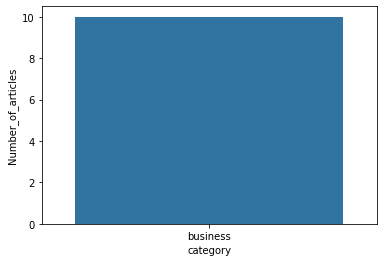

In [81]:
C4 = pd.DataFrame({'distance': news_cs[3].nsmallest(10)}).join(articles_train)
catagory_counts = pd.DataFrame(C4.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

Cluster 5:

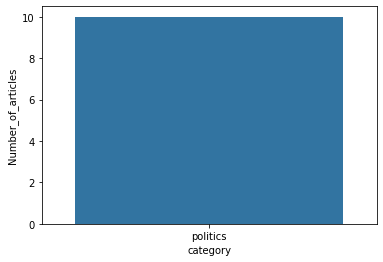

In [82]:
C5 = pd.DataFrame({'distance': news_cs[4].nsmallest(10)}).join(articles_train)
catagory_counts = pd.DataFrame(C5.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

Cluster 6:

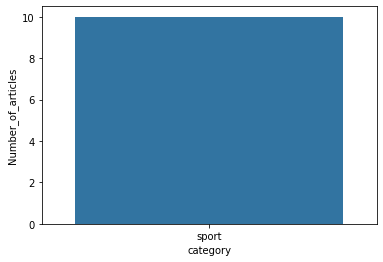

In [83]:
C6 = pd.DataFrame({'distance': news_cs[5].nsmallest(10)}).join(articles_train)
catagory_counts = pd.DataFrame(C6.groupby(['category'])['value'].count())
catagory_counts = catagory_counts.reset_index()
catagory_counts = catagory_counts.rename(columns = {"value": "Number_of_articles"})
ax = sns.barplot(x="category", y="Number_of_articles", data=catagory_counts)

In [ ]:
silhouette_score(imat, kmeans.labels_)